In [283]:
import os
from pathlib import Path
import uuid
import torch
from torch.utils.data import random_split
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from celldreamer.paths import TRAINING_FOLDER
from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.denoising_model import MLPTimeStep
from celldreamer.models.fm.fm import FM
from celldreamer.models.base.encoder_model import EncoderModel
import time
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt 
matplotlib.rcdefaults()

matplotlib_rc = { 
    # 'text': {'usetex': True}, 
    'font': {'family': 'serif'} } # Apply changes for k, v in matplotlib_rc.items(): rc(k, **v)
for k, v in matplotlib_rc.items():
          rc(k, **v)

In [284]:
def init_feature_embeddings(n_emb=100):
    """
    Initialize feature embeddings either for drugs or covariates 
    """
    # Contains the embedding class of multiple feature types
    feature_embeddings = {}  
    num_classes = {}
            
    feature_embeddings["cell_type"] = CategoricalFeaturizer(3,
                                                            False, 
                                                            "cuda", 
                                                            embedding_dimensions=n_emb)
    num_classes["cell_type"] = 3
    return feature_embeddings

feature_embeddings = init_feature_embeddings()

In [285]:
# Some general settings for the run
os.environ["WANDB__SERVICE_WAIT"] = "300"
torch.autograd.set_detect_anomaly(True)

In [286]:
number_of_genes = [2000, 5000, 10000, 20000, 30000, 40000]
latent_size = [10,50,100,500,1000]
number_of_cells = [100, 10000, 50000, 100000, 500000, 1000000]
embedding_dim = [10, 30, 50, 100, 200, 500]
hidden_dim = [16, 32, 64, 128, 256, 512]
n_blocks = [2, 3, 4, 5, 6]

In [287]:
def run_synth_experiment_with_time(n_genes, 
                                   n_latents,
                                   n_cells,
                                   n_embs, 
                                   n_hiddens, 
                                   n_blocks, 
                                  feature_embs):
    
    encoder_model = EncoderModel(in_dim=n_genes,
                                  n_cat=3,
                                  conditioning_covariate="cell_type", 
                                  encoder_type="learnt_autoencoder",
                                  x0_from_x_kwargs={"dims": [n_latents*5, n_latents*4, n_latents],
                                                    "batch_norm": True,
                                                    "dropout": False, 
                                                    "dropout_p": 0.0},
                                  learning_rate=0.001,
                                  weight_decay=0.00001,
                                  covariate_specific_theta=False,
                                  multimodal=False,
                                  is_binarized=False).to("cuda")

    denoising_model = MLPTimeStep(in_dim=n_latents, 
                                    hidden_dim=n_hiddens,
                                    dropout_prob=0,
                                    n_blocks=n_blocks, 
                                    model_type="conditional_latent", 
                                    size_factor_min=0, 
                                    size_factor_max=0,
                                    embedding_dim=n_embs,
                                    normalization="none",
                                    conditional=True, 
                                    multimodal=False, 
                                    is_binarized=False, 
                                    modality_list=["rna"], 
                                    embed_size_factor=False).to("cuda")

    size_factor_statistics = {"mean": {"cell_type":[1,1,1]}}


    generative_model = FM(
                encoder_model=encoder_model,
                denoising_model=denoising_model,
                feature_embeddings=feature_embs,
                plotting_folder="",
                in_dim=n_genes,
                size_factor_statistics=size_factor_statistics,
                encoder_type="learnt_autoencoder",
                conditioning_covariate="cell_type",
                model_type="conditional_latent", 
                multimodal=False,
                is_binarized=False,
                modality_list=["rna"],
                learning_rate=0.0001, 
                weight_decay=0.000001,
                antithetic_time_sampling=True,
                sigma=0.0001,
                use_ot=False
                ).to("cuda")
    
    t0 = time.time()
    if n_cells>10000:
        X_generated = generative_model.batched_sample(batch_size=10000,
                                                        repetitions=n_cells//10000,
                                                        n_sample_steps=2, 
                                                        covariate="cell_type", 
                                                        covariate_indices=1*torch.ones(n_cells).long().cuda(), 
                                                        log_size_factor=(torch.ones(n_cells).unsqueeze(1)*5).cuda())
    else:
        X_generated = generative_model.sample(batch_size=n_cells,
                            n_sample_steps=2, 
                            covariate="cell_type", 
                            covariate_indices=1*torch.ones(n_cells).long().cuda(), 
                            log_size_factor=(torch.ones(n_cells).unsqueeze(1)*5).cuda())
    t1 = time.time()
    return t1-t0

## Time results number of cells vs latents 

In [238]:
results_number_of_cells = {"Time": [],
                          "Number of latents": [], 
                          "Number of cells": []
                          }

In [239]:
for n_latents in latent_size:
    for n_cells in number_of_cells:
        t = run_synth_experiment_with_time(2000, n_latents, n_cells, 100, 64, 3, feature_embeddings)
        results_number_of_cells["Time"].append(t)
        results_number_of_cells["Number of cells"].append(n_cells)
        results_number_of_cells["Number of latents"].append(n_latents)

In [240]:
results_number_of_cells_df = pd.DataFrame(results_number_of_cells)

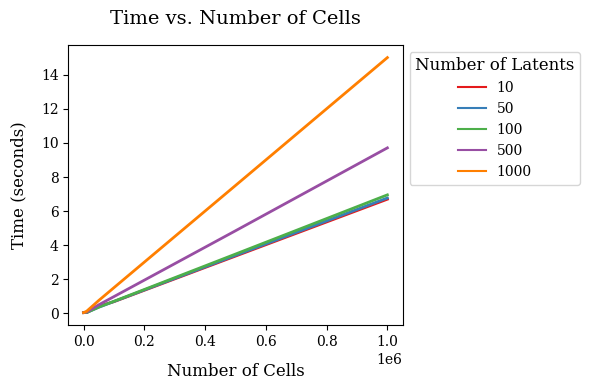

In [241]:
# Create the figure and plot
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=results_number_of_cells_df, 
    x="Number of cells", 
    y="Time", 
    hue="Number of latents", 
    palette="Set1",  # Use a visually appealing color palette
    linewidth=2         # Thicker lines for better visibility
)

# Enhance labels and add a title
plt.xlabel("Number of Cells", fontsize=12, labelpad=10)
plt.ylabel("Time (seconds)", fontsize=12, labelpad=10)
plt.title("Time vs. Number of Cells", fontsize=14, pad=15)

# Improve legend placement and title
plt.legend(title="Number of Latents", title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.savefig("time_vs_number_of_cells.svg", dpi=300, bbox_inches='tight', format="svg")
plt.show()

## Time results number of genes vs latent size

In [ ]:
results_number_of_genes = {"Time": [],
                          "Number of latents": [], 
                          "Number of genes": []
                          }

In [230]:
for n_latents in latent_size:
    for n_genes in number_of_genes:
        t = run_synth_experiment_with_time(n_genes, n_latents, 50000,100, 64, 3, feature_embeddings)
        results_number_of_genes["Time"].append(t)
        results_number_of_genes["Number of genes"].append(n_genes)
        results_number_of_genes["Number of latents"].append(n_latents)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


In [231]:
results_number_of_genes_df = pd.DataFrame(results_number_of_genes)

In [232]:
results_number_of_genes_df

,Time,Number of latents,Number of genes
0,0.330625,10,2000
1,0.600659,10,5000
2,1.065082,10,10000
3,2.002038,10,20000
4,2.911288,10,30000
5,3.876463,10,40000
6,0.328371,50,2000
7,0.611815,50,5000
8,1.086712,50,10000
9,2.034107,50,20000


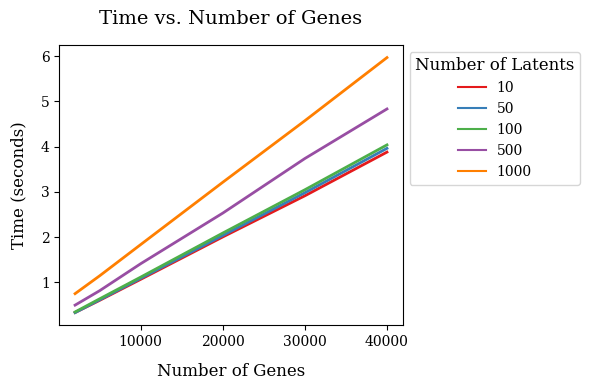

In [233]:
# Create the figure and plot
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=results_number_of_genes_df, 
    x="Number of genes", 
    y="Time", 
    hue="Number of latents", 
    palette="Set1",  # Use a visually appealing color palette
    linewidth=2         # Thicker lines for better visibility
)

# Enhance labels and add a title
plt.xlabel("Number of Genes", fontsize=12, labelpad=10)
plt.ylabel("Time (seconds)", fontsize=12, labelpad=10)
plt.title("Time vs. Number of Genes", fontsize=14, pad=15)

# Improve legend placement and title
plt.legend(title="Number of Latents", title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.savefig("time_vs_number_of_genes.svg", dpi=300, bbox_inches='tight', format="svg")
plt.show()

## Time results embedding size vs latent size

In [268]:
results_number_of_embeddings = {"Time": [],
                                  "Number of latents": [], 
                                  "Embedding size": []
                                  }

In [269]:
for n_latents in latent_size:
    for n_emb in embedding_dim:
        feature_embeddings_diff = init_feature_embeddings(n_emb)
        t = run_synth_experiment_with_time(20000, n_latents, 50000, n_emb, 64, 3, feature_embeddings_diff)
        results_number_of_embeddings["Time"].append(t)
        results_number_of_embeddings["Embedding size"].append(n_emb)
        results_number_of_embeddings["Number of latents"].append(n_latents)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


In [270]:
results_number_of_embeddings_df = pd.DataFrame(results_number_of_embeddings)

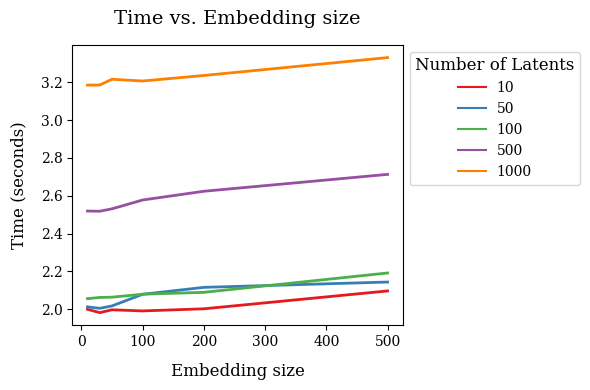

In [271]:
# Create the figure and plot
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=results_number_of_embeddings_df, 
    x="Embedding size", 
    y="Time", 
    hue="Number of latents", 
    palette="Set1",  # Use a visually appealing color palette
    linewidth=2         # Thicker lines for better visibility
)

# Enhance labels and add a title
plt.xlabel("Embedding size", fontsize=12, labelpad=10)
plt.ylabel("Time (seconds)", fontsize=12, labelpad=10)
plt.title("Time vs. Embedding size", fontsize=14, pad=15)

# Improve legend placement and title
plt.legend(title="Number of Latents", title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.savefig("time_vs_embedding_size.svg", dpi=300, bbox_inches='tight', format="svg")
plt.show()

## Time results hidden layers vs latent size

In [272]:
results_number_of_hidden_dim = {"Time": [],
                                  "Number of latents": [], 
                                  "Hidden layer": []
                                  }

In [273]:
for n_latents in latent_size:
    for n_hidden in hidden_dim:
        t = run_synth_experiment_with_time(20000, n_latents, 50000, 100, n_hidden, 3, feature_embeddings)
        results_number_of_hidden_dim["Time"].append(t)
        results_number_of_hidden_dim["Hidden layer"].append(n_hidden)
        results_number_of_hidden_dim["Number of latents"].append(n_latents)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


In [274]:
results_hidden_dim_df = pd.DataFrame(results_number_of_hidden_dim)

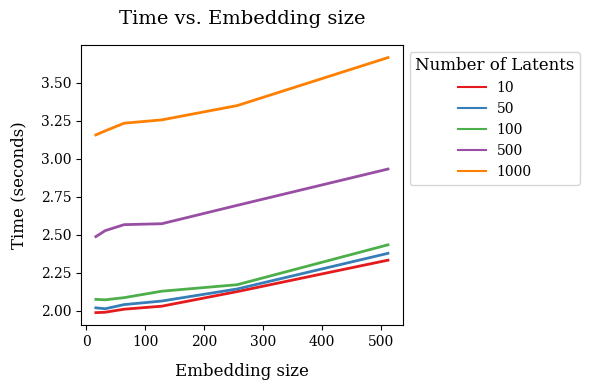

In [275]:
# Create the figure and plot
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=results_hidden_dim_df, 
    x="Hidden layer", 
    y="Time", 
    hue="Number of latents", 
    palette="Set1",  # Use a visually appealing color palette
    linewidth=2         # Thicker lines for better visibility
)

# Enhance labels and add a title
plt.xlabel("Hidden dimenison", fontsize=12, labelpad=10)
plt.ylabel("Time (seconds)", fontsize=12, labelpad=10)
plt.title("Time vs. Hidden dimenison", fontsize=14, pad=15)

# Improve legend placement and title
plt.legend(title="Number of Latents", title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.savefig("time_vs_hidden_dim.svg", dpi=300, bbox_inches='tight', format="svg")
plt.show()

## Time results number of blocks vs latent size

In [298]:
results_number_of_blocks = {"Time": [],
                              "Number of latents": [], 
                              "Number of blocks": []
                              }

In [299]:
for n_latents in latent_size:
    for n_block in n_blocks:
        t = run_synth_experiment_with_time(20000, n_latents, 50000, 100, 64, n_block, feature_embeddings)
        results_number_of_blocks["Time"].append(t)
        results_number_of_blocks["Number of blocks"].append(n_block)
        results_number_of_blocks["Number of latents"].append(n_latents)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


In [300]:
results_number_of_blocks_df = pd.DataFrame(results_number_of_blocks)

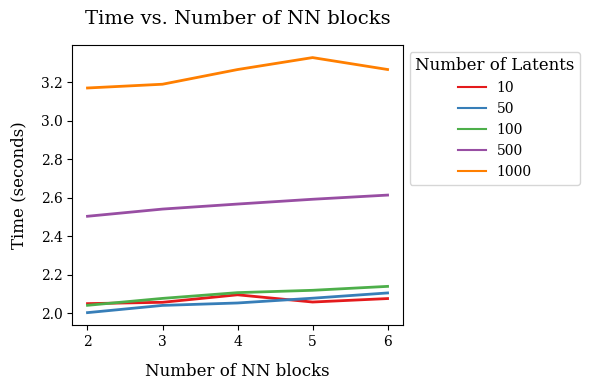

In [302]:
# Create the figure and plot
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=results_number_of_blocks_df, 
    x="Number of blocks", 
    y="Time", 
    hue="Number of latents", 
    palette="Set1",  # Use a visually appealing color palette
    linewidth=2         # Thicker lines for better visibility
)

# Enhance labels and add a title
plt.xlabel("Number of NN blocks", fontsize=12, labelpad=10)
plt.ylabel("Time (seconds)", fontsize=12, labelpad=10)
plt.title("Time vs. Number of NN blocks", fontsize=14, pad=15)

# Improve legend placement and title
plt.legend(title="Number of Latents", title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.savefig("time_vs_n_blocks.svg", dpi=300, bbox_inches='tight', format="svg")
plt.show()